In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [4]:
import models.segmentation_models_qubvel as sm
from utils.augmentation import get_preprocessing
from utils.smooth_tiled_predictions import predict_img_with_smooth_windowing

Segmentation Models: using `keras` framework.


In [6]:
def visualize_ir(img, idx=None, cmap='cividis', colorbar=False, save_path=None):
    plt.imshow(img, cmap=cmap)

    if colorbar:
        plt.colorbar()
    
    if not save_path==None:
        #cv2.imwrite(os.path.join(save_path, '{}.png'.format(idx)), img)
        plt.imsave(os.path.join(save_path, '{}.png'.format(idx)), img, cmap='gray')

In [7]:
def expand_greyscale_channels(image):
    image = np.expand_dims(image, -1)
    image = image.repeat(3, axis=-1)
    return image


def crop_center_square(image, im_size=480):
    size=im_size
    height, width = image.shape[:2]
    new_width = new_height = size
    left = (width - new_width) // 2
    top = (height - new_height) // 2
    right = left + new_width
    bottom = top + new_height
    cropped_image = image[top:bottom, left:right]
    return cropped_image

def label_to_pixelvalue(image):
    uniques = np.unique(image)
    
    for idx,elem in enumerate(uniques):
        mask = np.where(image == 1)
        image[mask] = 125
        mask2 = np.where(image == 2)
        image[mask2] = 255
    return image

def preprocess_prediction(image, model_preprocessing, smooth=False):
    image = expand_greyscale_channels(image)

    # create mask of zeros such that preprocessing function works
    random_mask = np.zeros(image.shape)

    sample = model_preprocessing(image=image, mask=random_mask)
    image, _ = sample['image'], sample['mask']
    image = image.astype(np.float32)

    if not smooth:
        # will add a dimension that replaces batch_size
        image = np.expand_dims(image, axis=0)
        # if smooth, function takes care of this
    
    return image

In [8]:
def patch_predict(model, image, patch_size, model_preprocessing):
    """
    Predicts on image patches and recombines masks to whole image later.
    
    This function is inspired by
    https://github.com/bnsreenu/python_for_microscopists/blob/master/206_sem_segm_large_images_using_unet_with_custom_patch_inference.py
    
    """

    # initialize mask with zeros
    segm_img = np.zeros(image.shape[:2])
    patch_num=1
    # Iterates through image in steps of patch_size, operates on patches
    for i in range(0, image.shape[0], patch_size):
        for j in range(0, image.shape[1], patch_size):
            single_patch = image[i:i+patch_size, j:j+patch_size]
            single_patch_shape = single_patch.shape[:2]
            single_patch = preprocess_prediction(single_patch, model_preprocessing=model_preprocessing)
            pr_mask = model.predict(single_patch)
            # removes batch dimension and channel dimension by replacing the latter with class with maximum probability value
            pr_mask_processed = np.argmax(pr_mask.squeeze(), axis=2)
            # make mask values visible
            fin = label_to_pixelvalue(pr_mask_processed)
            # recombine to complete image
            segm_img[i:i+single_patch_shape[0], j:j+single_patch_shape[1]] += cv2.resize(fin, single_patch_shape[::-1])
            print("Finished processing patch number ", patch_num, " at position ", i,j)
            patch_num+=1

    return segm_img

In [9]:
def smooth_patch_predict(model, image, patch_size, model_preprocessing, smooth):
    """
    https://github.com/bnsreenu/python_for_microscopists/tree/master/229_smooth_predictions_by_blending_patches
    
    How this should work: 
    Motivation: There might be high error on the predictions made near the outside of the window,
    predictions are just concatenated.

    - uses 2D interpolation between overlapping patches when doing final predictions
    - split image into patches, using a 5D np array (ordering in space can require two extra
    dimensions?)
    - reshape those patches to 4D with along a single batch size to be passed into the prediction function
    - put predictions together back into 5D array to be merged with a spline interpolation to a regular 3D array

    - first, use roation and mirroring so as to make the NN view the image under several different angles
    - this is averaged out and thus reduces variance in the predictions
    - predictions are blended together using interpolation with a simple second order spline window function:
    weighting pixels when merging patches together
    - amount of overlap between merged windows can be changed

    """

    input_image = preprocess_prediction(image, model_preprocessing=model_preprocessing, smooth=smooth)
    print(input_image.shape)
    predictions_smooth = predict_img_with_smooth_windowing(
        input_image,
        window_size=patch_size,
        subdivisions = 4, # minimal amount of overlap - must be an even number
        nb_classes = 3,
        pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
        )
    )

    final_prediction = np.argmax(predictions_smooth.squeeze(), axis=2)
    final_prediction = label_to_pixelvalue(final_prediction)

    return final_prediction

In [10]:
def predict(img, im_size, weights, backbone='resnet34', train_transfer='imagenet', smooth=False, save_path=None):
    
    if not im_size==480:
        img = crop_center_square(img, 256)
    
    BACKBONE = backbone
    TRAIN_TRANSFER = train_transfer
    WEIGHTS = weights

    prepro = get_preprocessing(sm.get_preprocessing(BACKBONE))

    model = sm.Unet(BACKBONE, input_shape=(im_size, im_size, 3), classes=3, activation='softmax', encoder_weights=TRAIN_TRANSFER)
    model.load_weights(weights)

    if smooth:
        segmented_image = smooth_patch_predict(model, img, im_size, model_preprocessing=prepro, smooth=True)
    else:
        segmented_image = patch_predict(model, img, im_size, model_preprocessing=prepro)
    #segmented_image = segmented_image.squeeze()
    visualize_ir(segmented_image)
    cv2.imwrite(save_path, segmented_image)

In [11]:
# prediction images (cropped and grayscale)
flight9_dir = 'E:/polar/code/data/evaluation/qualitative/flight9/'
flight16_dir = 'E:/polar/code/data/evaluation/qualitative/flight16/'

weights_final = 'weights/best_modelfinal_run100.h5'

1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 5s 5s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 4s 4s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 3s 3s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 3s 3s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0


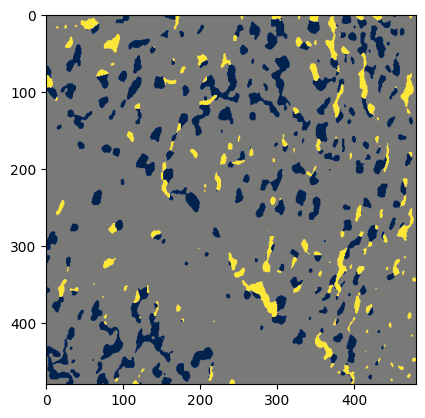

In [13]:
for idx, file in enumerate(os.listdir(flight9_dir)):
    img = cv2.imread(os.path.join(flight9_dir, file), 0)
    predict(img, 480, weights_final, backbone='resnet34', train_transfer='imagenet', save_path='E:/polar/code/data/evaluation/qualitative/pred_9/{}.png'.format(idx))

1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 3s 3s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0
1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0


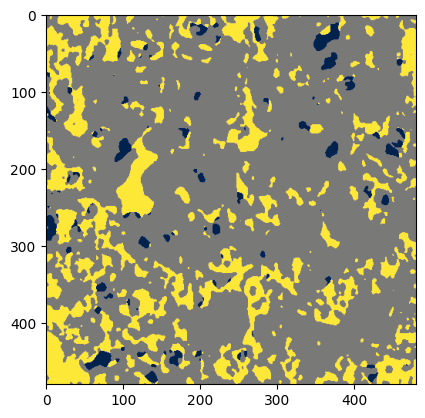

In [14]:
for idx, file in enumerate(os.listdir(flight16_dir)):
    img = cv2.imread(os.path.join(flight16_dir, file), 0)
    predict(img, 480, weights_final, backbone='resnet34', train_transfer='imagenet', save_path='E:/polar/code/data/evaluation/qualitative/pred_16/{}.png'.format(idx))